# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import time
%matplotlib inline

Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


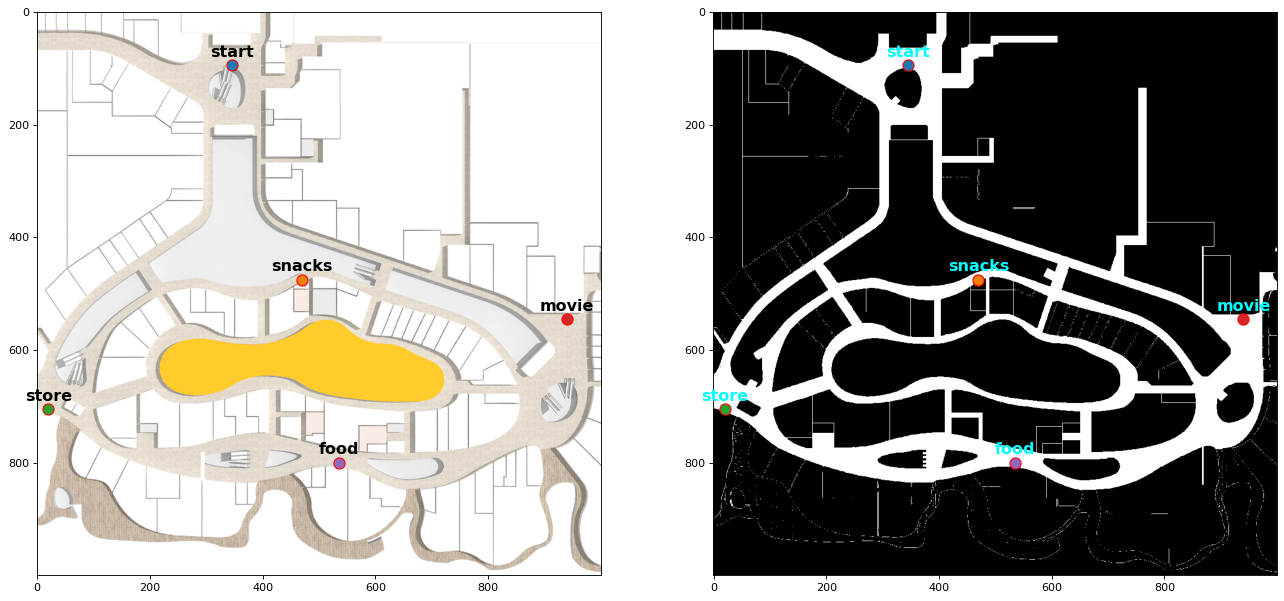

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [48]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

## Task 1

In [49]:
heuristic = 'euclidean'
class Node:
    def __init__(self, x, y, cost, parent):
        self.x = x
        self.y = y
        self.cost = cost
        self.parent = parent

class A_star_planning:
    def __init__(self, grid_map, heuristic):
        self.grid_map = grid_map
        self.max_x, self.max_y = grid_map.shape
        self.heuristic = heuristic # change this for different heuristic functions

        self.success = False

        self.priority_queue = {}
        self.visited = {}

    def get_neighbors(self, x, y):
        neighbors = []
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                nx = x + dx
                ny = y + dy
                if 0 <= nx < self.max_x and 0 <= ny < self.max_y:
                    neighbors.append((nx, ny))
        return neighbors
  
    def inflate_obstacles(self):
        inflated_map = self.grid_map.copy()
        free_indices = np.array(np.where(self.grid_map == 255)).T

        for fx, fy in free_indices:
            neighbors = self.get_neighbors(fx, fy)
            for nx, ny in neighbors:
                if self.grid_map[nx, ny] == 0:
                    inflated_map[fx, fy] = 0
                    break
        self.inflated_map = inflated_map
        return
    
    def algorithm(self, start_pos:tuple, goal_pos: tuple):

        start_node = Node(start_pos[0], start_pos[1], 0.0, None)
        goal_node = Node(goal_pos[0], goal_pos[1], 0.0, None)

        self.priority_queue[(start_node.x, start_node.y)] = start_node

        while True:
            if len(self.priority_queue) == 0:
                print(f"The priority queue has no Nodes")
                break

            cur_index = min(self.priority_queue, key=lambda o: self.priority_queue[o].cost + self.calc_heuristic(goal_node, self.priority_queue[o], self.heuristic))
            curr_node = self.priority_queue[cur_index]

            if curr_node.x == goal_node.x and curr_node.y == goal_node.y:
                print("Reached the goal.")
                self.success = True
                goal_node = curr_node
                break
            
            del self.priority_queue[cur_index]
            self.visited[cur_index] = curr_node

            neighbors = self.get_neighbors(curr_node.x, curr_node.y)

            for ix, iy in neighbors:
                if self.inflated_map[ix, iy] == 0:
                    continue  # skip if it's an obstacle

                if (ix, iy) in self.visited:
                    continue  # already explored

                step_cost = 0.2 if abs(ix - curr_node.x) + abs(iy - curr_node.y) == 1 else 0.282
                new_cost = curr_node.cost + step_cost

                if (ix, iy) not in self.priority_queue or new_cost < self.priority_queue[(ix, iy)].cost:
                    self.priority_queue[(ix, iy)] = Node(ix, iy, new_cost, curr_node)
            
        if self.success:
            total_distance = self.reconstruct_path(goal_node)
        else:
            print("No path found")
            total_distance = float("inf")

        return total_distance


    def calc_heuristic(self, goal_node, curr_node, heuristic):
        if heuristic == 'manhattan':
            return abs(goal_node.x - curr_node.x) + abs(goal_node.y - curr_node.y)
        elif heuristic == 'euclidean':
            return ((goal_node.x - curr_node.x) ** 2 + (goal_node.y - curr_node.y) ** 2) ** 0.5
        else:
            raise ValueError(f"Unknown heuristic type: {heuristic}")
    
    def reconstruct_path(self, goal_node):
        self.rx = []
        self.ry = []
        total_dist = goal_node.cost

        node = goal_node
        while node is not None:
            self.rx.append(node.x)
            self.ry.append(node.y)
            node = node.parent

        self.rx.reverse()
        self.ry.reverse()

        return total_dist

    def visualize(self, start_pos, goal_pos):
        plt.figure(figsize=(8, 8))
        plt.imshow(self.grid_map.T, cmap='gray', origin='lower')

        # Plot the path with dotted red line
        plt.plot(self.rx, self.ry, 'r--', linewidth=2.0, label='Path')

        # Plot start and goal points
        plt.plot(start_pos[0], start_pos[1], 'go', markersize=8, label='Start')
        plt.plot(goal_pos[0], goal_pos[1], 'bo', markersize=8, label='Goal')

        plt.legend()
        plt.title("A* Path Planning")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.grid(False)
        plt.show()

    def run(self, start_pos, goal_pos):
        start_time = time.time()
        self.inflate_obstacles()
        total_distance = self.algorithm(start_pos, goal_pos)
        self.visualize(start_pos, goal_pos)
        end_time = time.time()
        print(f"The run time for this is: {end_time-start_time:.4f} seconds")
        return self.rx, self.ry, total_distance
    
    def compare_inflated_grid(self):
        diff = (self.grid_map == 255) & (self.inflated_map == 0)
        # Visualize
        plt.imshow(diff, cmap='gray')
        plt.title("Inflated Area")
        plt.show()
        return

### The following shows the pixels that were actually free before but had to be made occupied because of the circular footprint of a human. (0.3 m > 0.2 m(resolution))

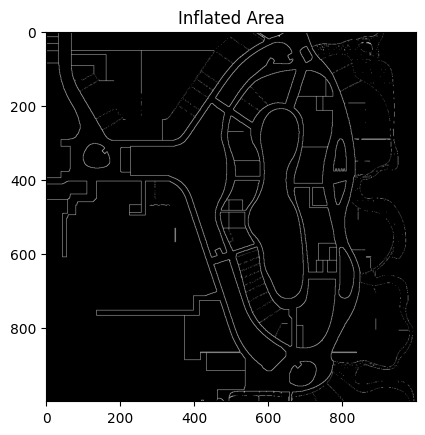

In [50]:
obj = A_star_planning(grid_map, heuristic)
obj.inflate_obstacles()
obj.compare_inflated_grid()

Planning from start to snacks...
Reached the goal.


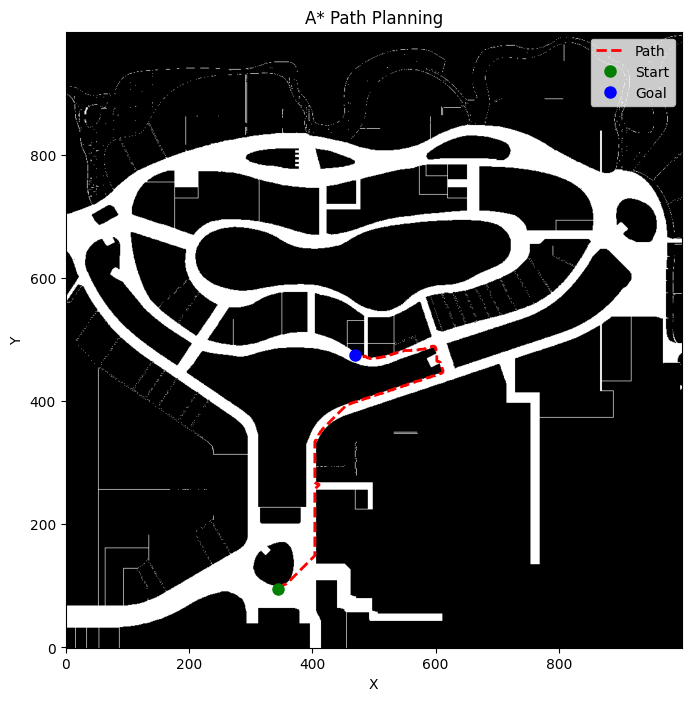

The run time for this is: 4.4839 seconds
Total cost from start to snacks is 144.34


Planning from start to store...
Reached the goal.


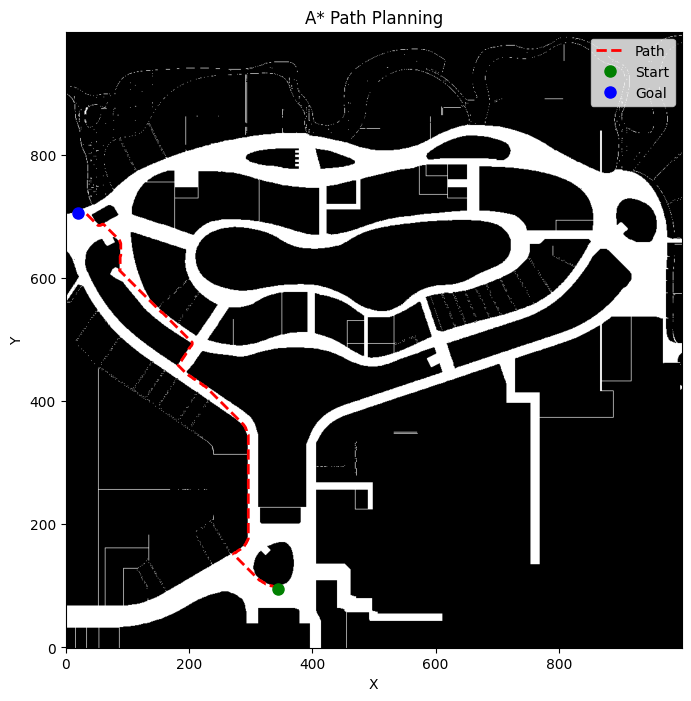

The run time for this is: 2.8525 seconds
Total cost from start to store is 163.62


Planning from start to movie...
Reached the goal.


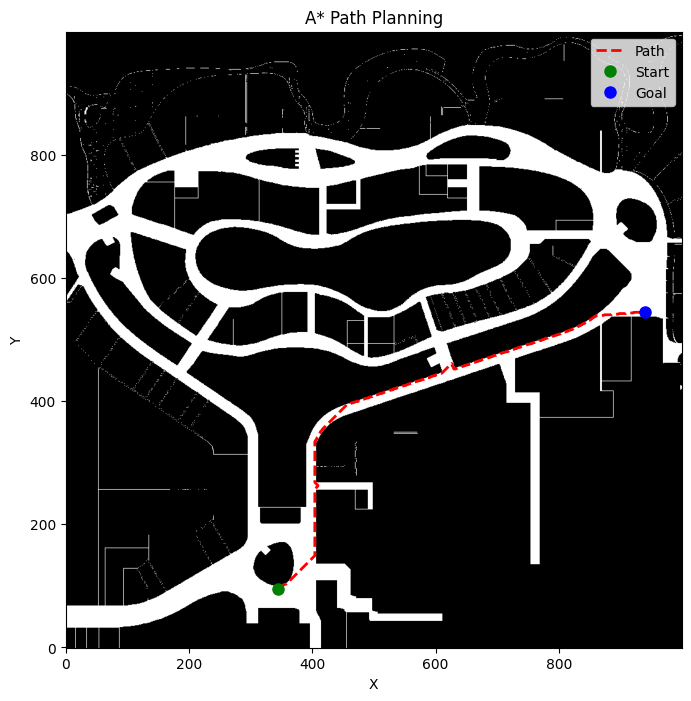

The run time for this is: 3.3223 seconds
Total cost from start to movie is 181.56


Planning from start to food...
Reached the goal.


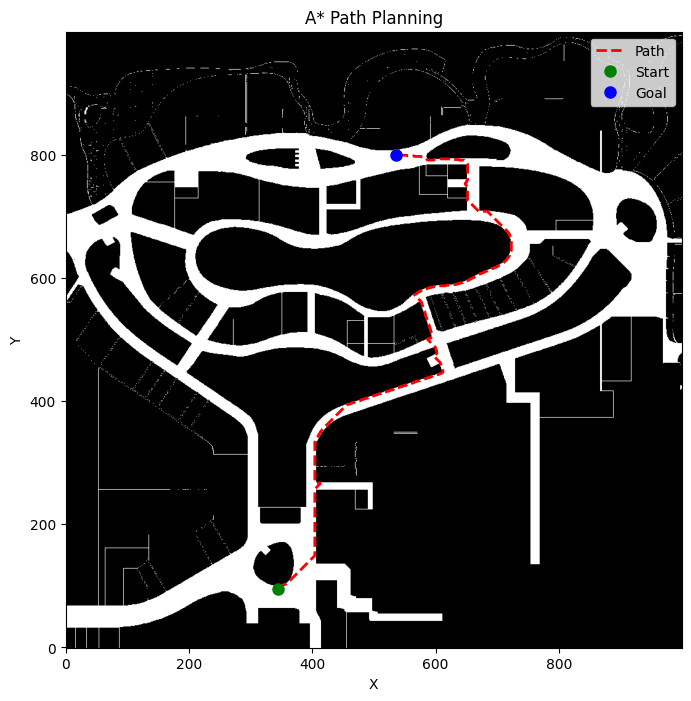

The run time for this is: 7.0851 seconds
Total cost from start to food is 238.13


Planning from snacks to start...
Reached the goal.


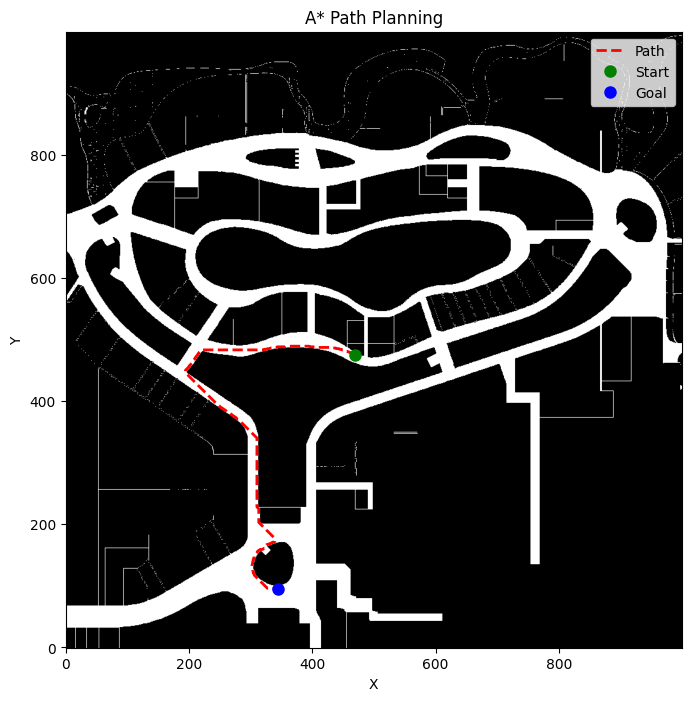

The run time for this is: 3.4400 seconds
Total cost from snacks to start is 154.78


Planning from snacks to store...
Reached the goal.


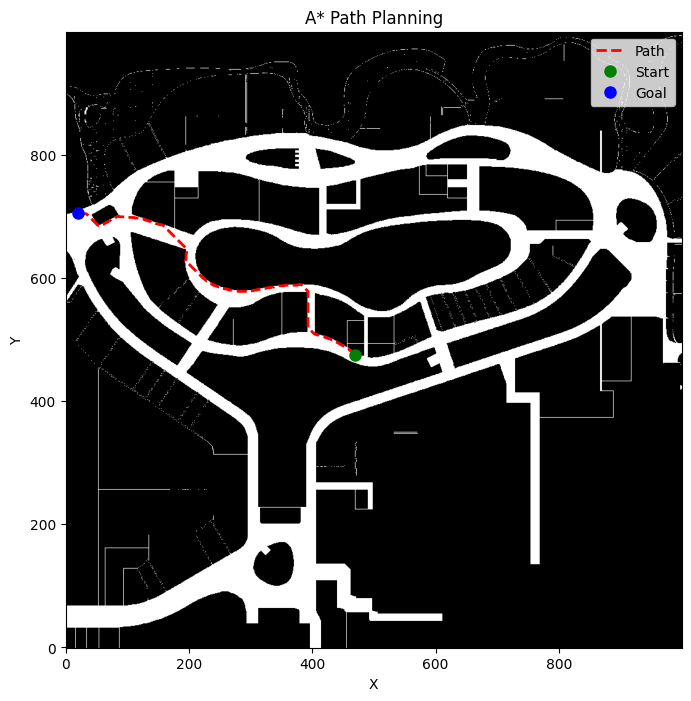

The run time for this is: 2.7056 seconds
Total cost from snacks to store is 122.89


Planning from snacks to movie...
Reached the goal.


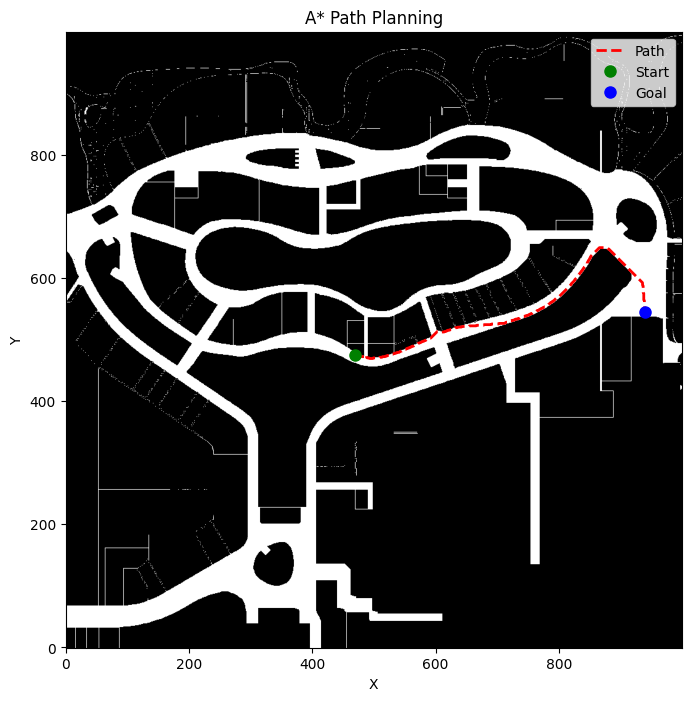

The run time for this is: 3.2220 seconds
Total cost from snacks to movie is 125.84


Planning from snacks to food...
Reached the goal.


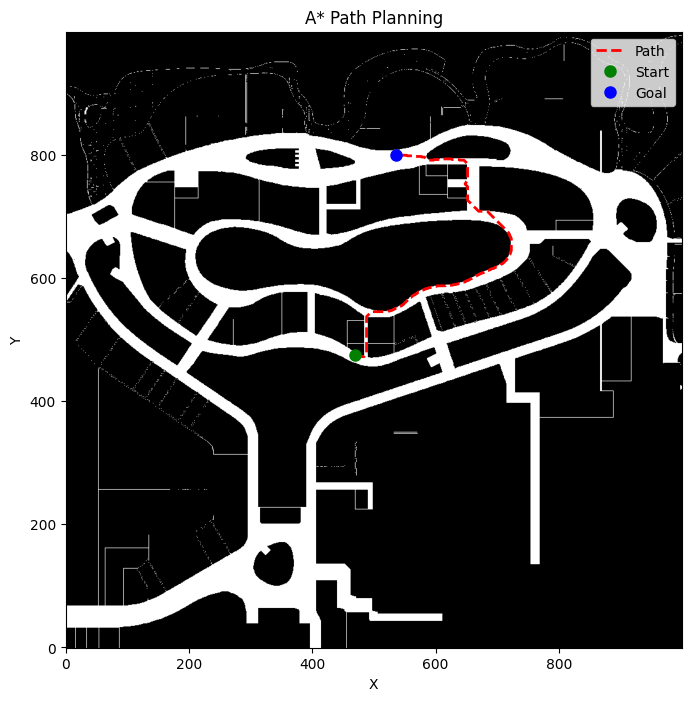

The run time for this is: 4.0273 seconds
Total cost from snacks to food is 134.38


Planning from store to start...
Reached the goal.


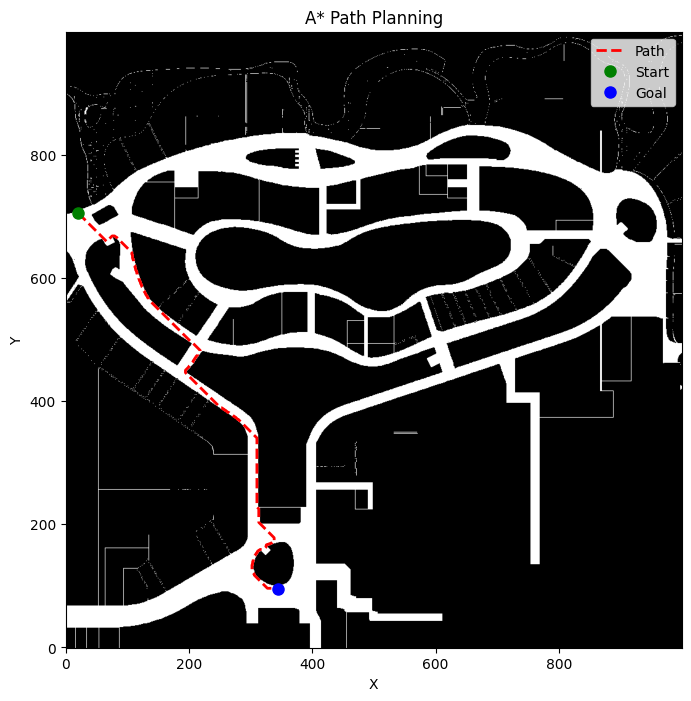

The run time for this is: 3.0728 seconds
Total cost from store to start is 167.92


Planning from store to snacks...
Reached the goal.


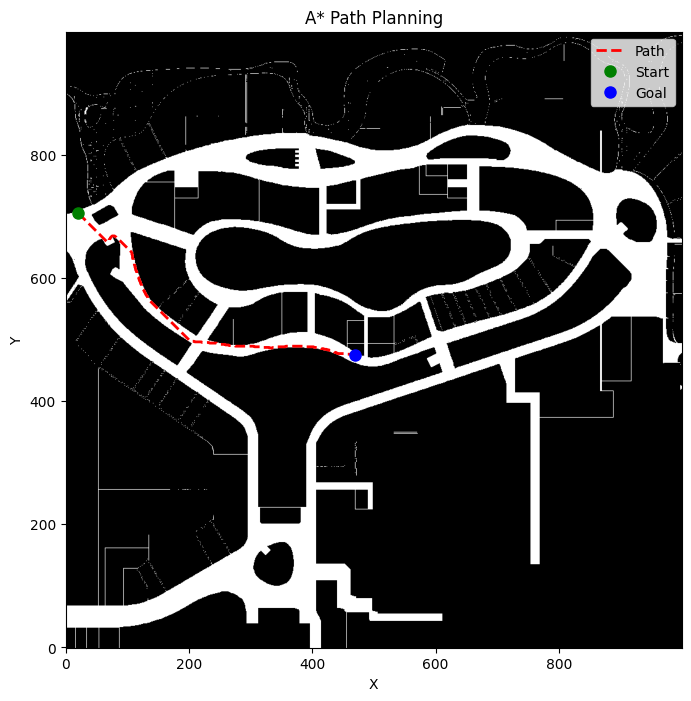

The run time for this is: 2.7475 seconds
Total cost from store to snacks is 117.13


Planning from store to movie...
Reached the goal.


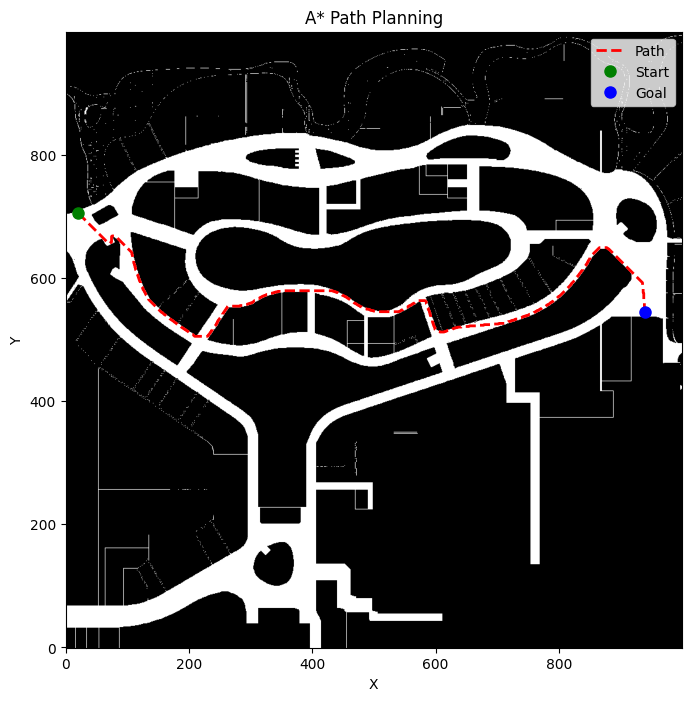

The run time for this is: 4.6590 seconds
Total cost from store to movie is 255.76


Planning from store to food...
Reached the goal.


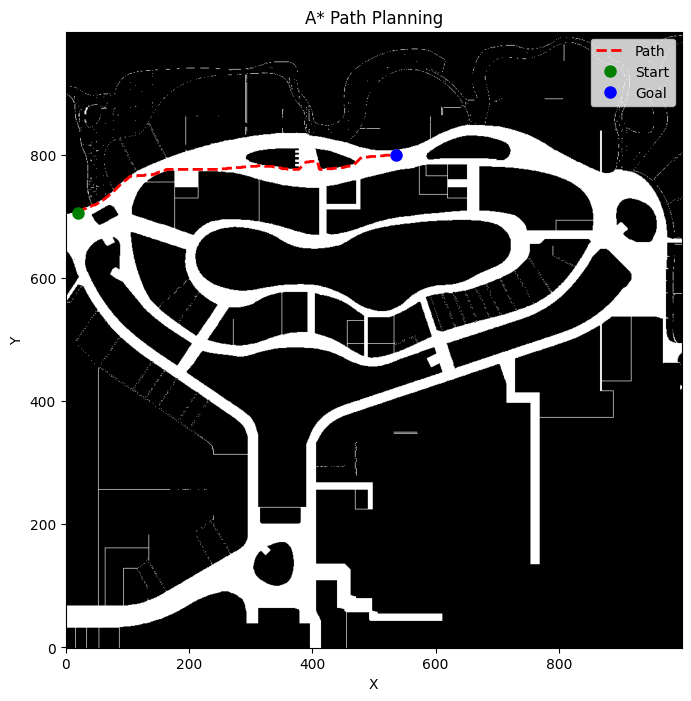

The run time for this is: 2.6807 seconds
Total cost from store to food is 114.97


Planning from movie to start...
Reached the goal.


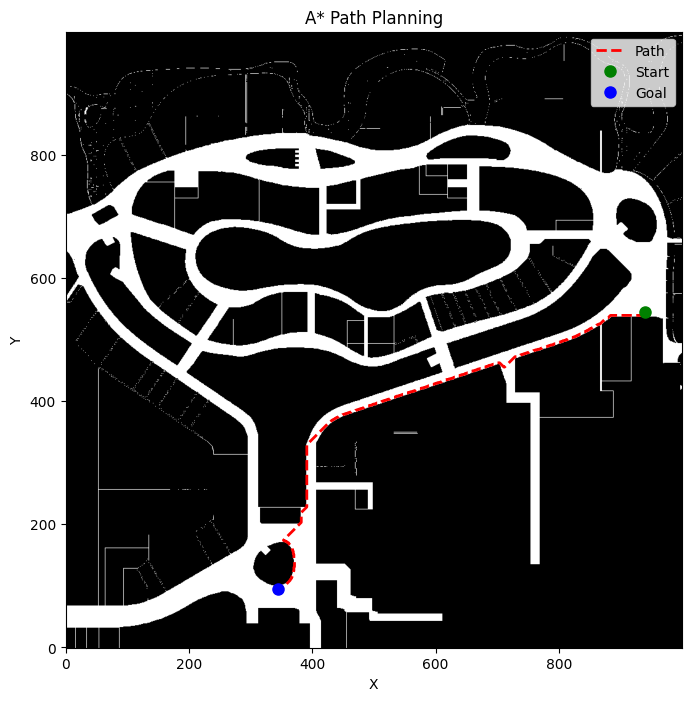

The run time for this is: 3.2277 seconds
Total cost from movie to start is 183.25


Planning from movie to snacks...
Reached the goal.


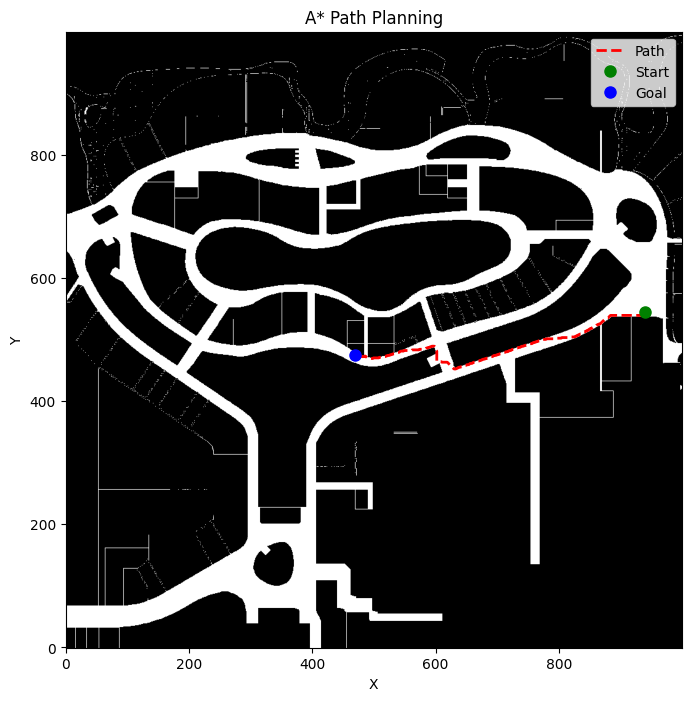

The run time for this is: 2.7630 seconds
Total cost from movie to snacks is 109.32


Planning from movie to store...
Reached the goal.


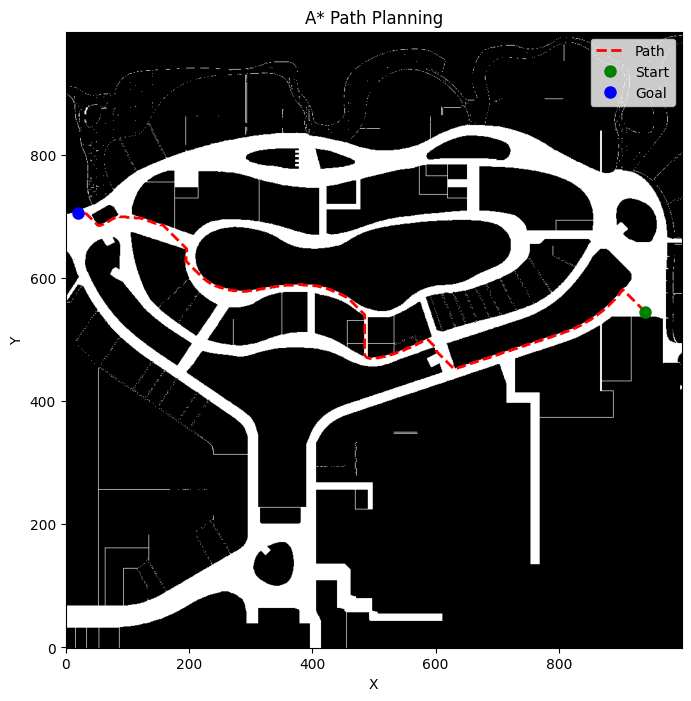

The run time for this is: 3.2450 seconds
Total cost from movie to store is 239.16


Planning from movie to food...
Reached the goal.


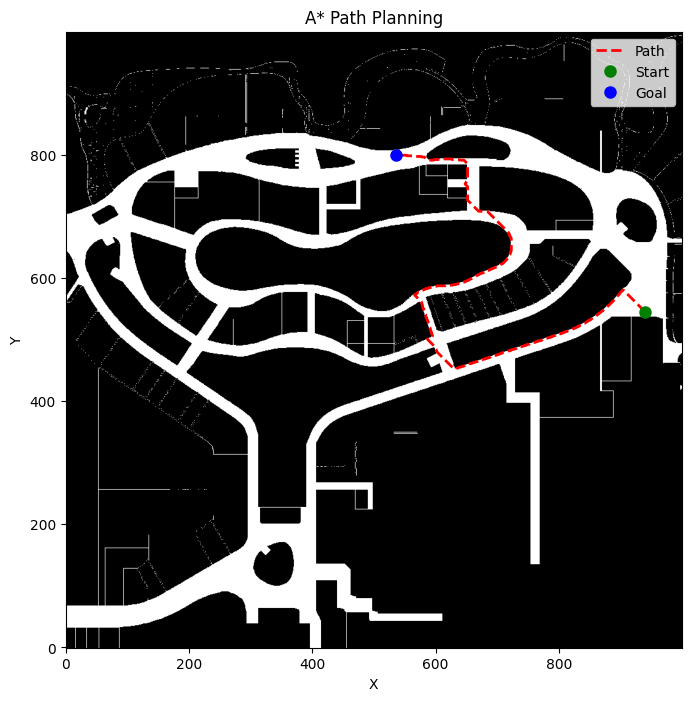

The run time for this is: 6.3200 seconds
Total cost from movie to food is 205.93


Planning from food to start...
Reached the goal.


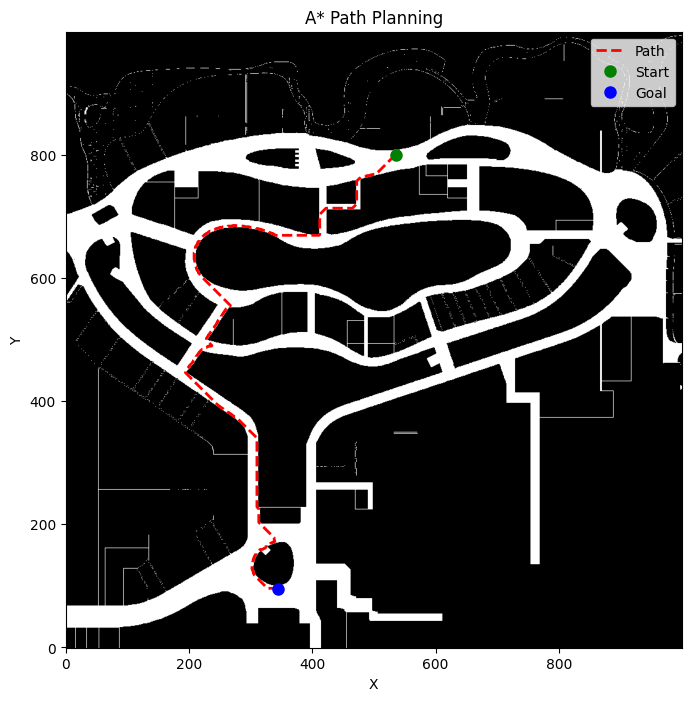

The run time for this is: 5.2950 seconds
Total cost from food to start is 237.18


Planning from food to snacks...
Reached the goal.


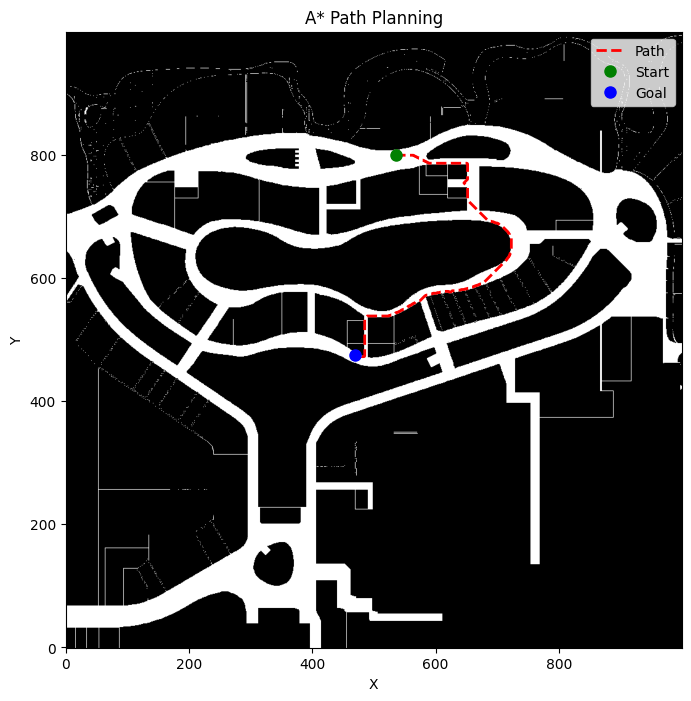

The run time for this is: 6.8059 seconds
Total cost from food to snacks is 134.43


Planning from food to store...
Reached the goal.


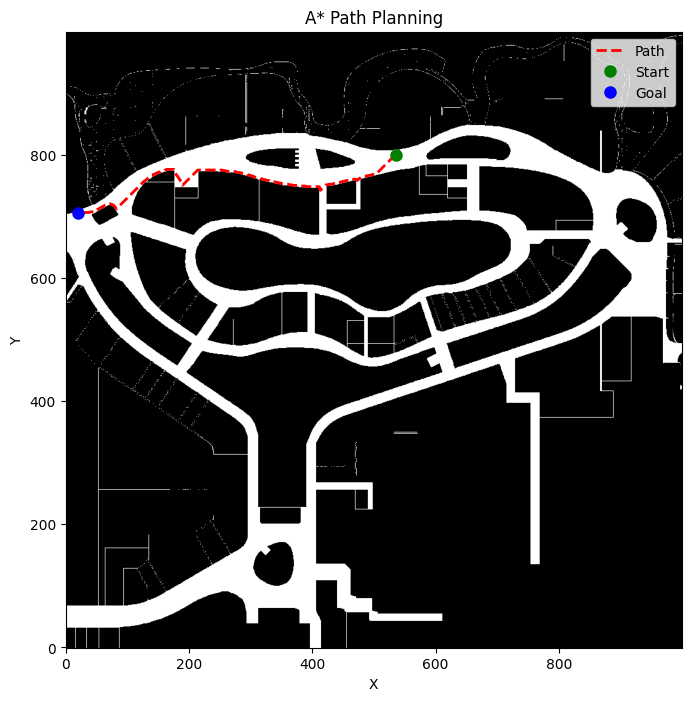

The run time for this is: 2.8149 seconds
Total cost from food to store is 124.39


Planning from food to movie...
Reached the goal.


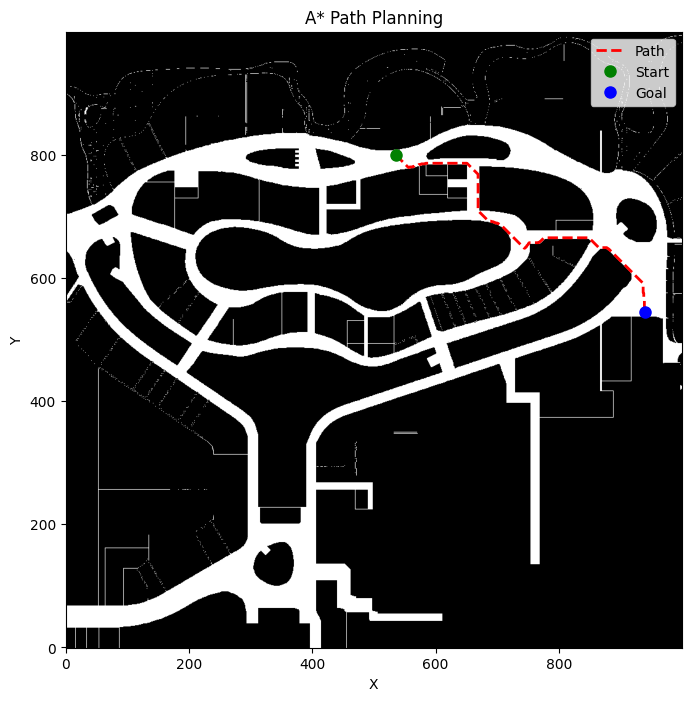

The run time for this is: 2.7162 seconds
Total cost from food to movie is 118.12




In [51]:
from itertools import permutations
results = {}

for (start_key, goal_key) in permutations(locations.keys(), 2):
    path_planning = A_star_planning(grid_map, heuristic)
    start = tuple(locations[start_key])
    goal = tuple(locations[goal_key])
    
    print(f"Planning from {start_key} to {goal_key}...")
    rx, ry, distance = path_planning.run(start, goal)
    print(f"Total cost from {start_key} to {goal_key} is {distance:.2f}")
    print("\n")
    results[(start_key, goal_key)] = distance

#### The following code is for visualising all paths on the same grid_map. before running the following code comment out the self.visualise() in the self.run() method - to prevenet priniting of all the plots once again

In [52]:
# plt.figure(figsize=(5, 5))

# # Show the grid map as background
# plt.imshow(grid_map, cmap='gray')  # or grid_map / 255.0

# # Loop through and overlay all paths
# for i, (start_key, goal_key) in enumerate(permutations(locations.keys(), 2)):
#     path_planner = A_star_planning(grid_map, heuristic)
#     start = tuple(locations[start_key])
#     goal = tuple(locations[goal_key])
    
#     rx, ry, _ = path_planner.run(start, goal)
    
#     plt.plot(ry, rx, label=f"{start_key}->{goal_key}")  # NOTE: ry for x-axis, rx for y-axis

# # Optional: Add keypoints
# for name, (x, y) in locations.items():
#     plt.plot(y, x, 'wo')  # White circles for key locations
#     plt.text(y, x, name, color='red', fontsize=8)

# plt.title("All A* Paths Overlaid on Map")
# plt.axis('off')
# plt.legend(fontsize=6)
# plt.tight_layout()
# plt.show()


## Task 2

In [56]:
# Brute Force
waypoints = ['snacks', 'store', 'movie', 'food']

min_cost = float('inf')
best_path = None

# Try all permutations of the waypoints
for perm in permutations(waypoints):
    path = ['start'] + list(perm) + ['start']  # start → ... → start
    total_cost = 0

    # Sum the distances between consecutive points
    for i in range(len(path) - 1):
        total_cost += results[(path[i], path[i+1])]

    # Update best path if this one is shorter
    if total_cost < min_cost:
        min_cost = total_cost
        best_path = path

# Output
print("Best route:", " → ".join(best_path))
print(f"Total travel distance: {min_cost:.2f} meters")

Best route: start → store → food → movie → snacks → start
Total travel distance: 660.80 meters


In [55]:
# Nearest Neighbour 
unvisited = {'snacks', 'store', 'movie', 'food'}
path = ['start']
total_cost = 0

current = 'start'

while unvisited:
    # Pick the nearest unvisited location
    next_node = min(unvisited, key=lambda node: results[(current, node)])
    total_cost += results[(current, next_node)]
    path.append(next_node)
    unvisited.remove(next_node)
    current = next_node

# Return to start
total_cost += results[(current, 'start')]
path.append('start')

# Output
print("Nearest Neighbor route:", " → ".join(path))
print(f"Total travel distance: {total_cost:.2f} meters")


Nearest Neighbor route: start → snacks → store → food → movie → start
Total travel distance: 683.56 meters


## Task 3

### The git repository for this code is - [My GitHub Repository for Homework 3](https://github.com/Praveen8978/ME5413_Homework_3.git)
